In [17]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(miloR)
options(ggrepel.max.overlaps = Inf)

In [18]:
source('milo_cellbender.R')

In [19]:
obj_neuron = qs::qread('_targets/objects/obj_neuron') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_neuron

An object of class Seurat 
29114 features across 104287 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



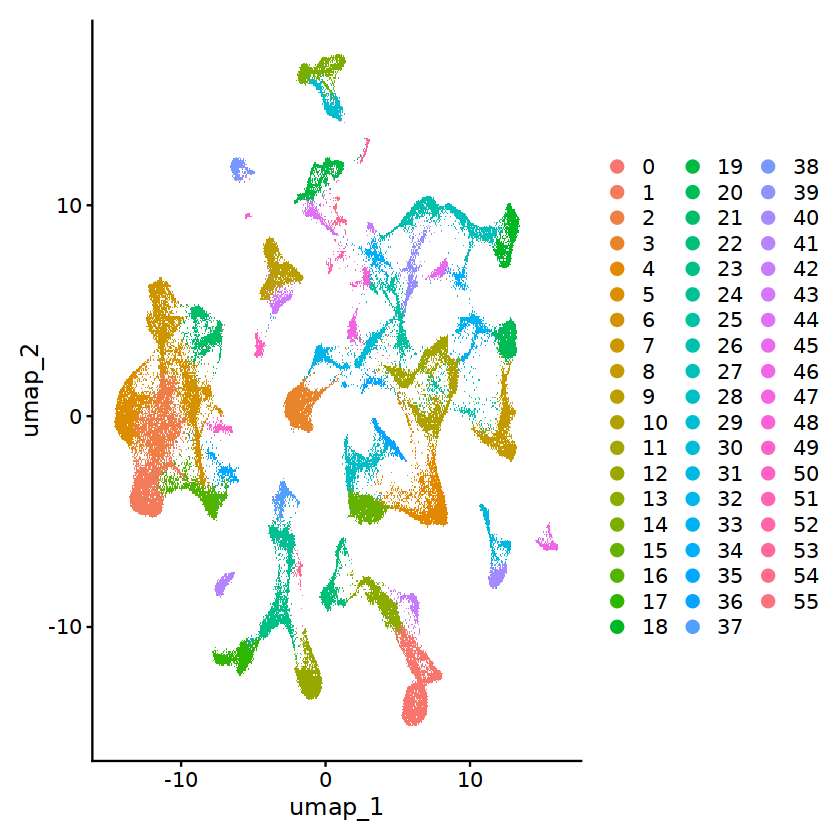

In [20]:
DimPlot(obj_neuron)

In [21]:
obj_other = qs::qread('_targets/objects/obj_other') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_other

An object of class Seurat 
25126 features across 32121 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

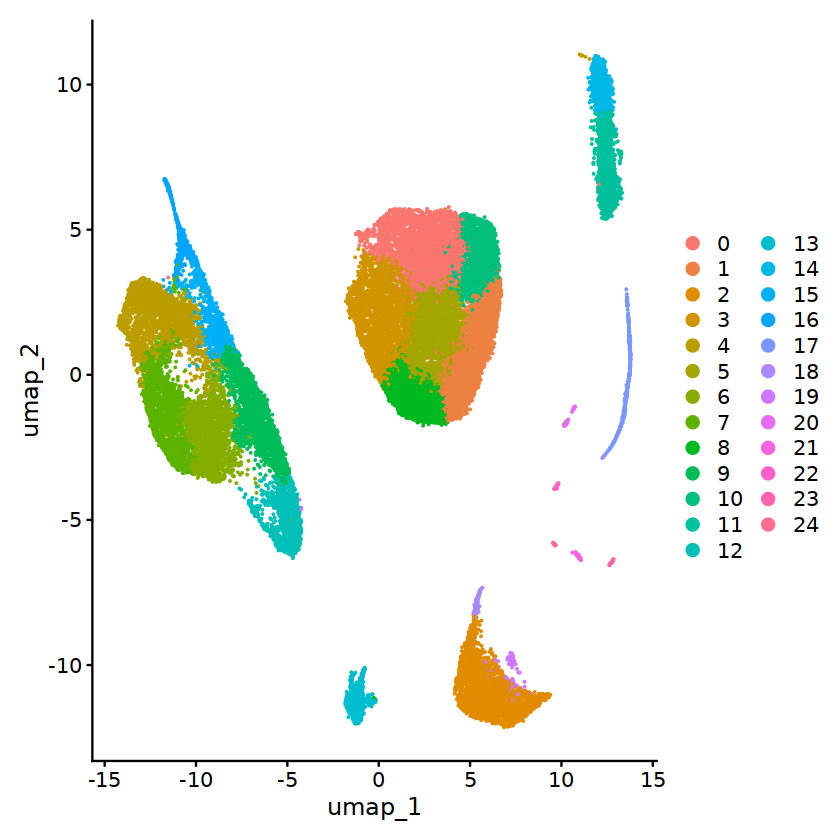

In [22]:
DimPlot(obj_other)

In [23]:
labels_classes_tib = (obj_other@meta.data %>% select(labels) %>% mutate(class = 'other') %>% tibble %>% distinct(labels, class)) %>%
bind_rows(obj_neuron@meta.data %>% select(labels) %>% mutate(class = 'neuron') %>% tibble %>% distinct(labels, class)) %>%
mutate(labels = str_replace(labels, fixed('-'), '__'))


In [24]:
umap_coords_neuron = obj_neuron %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_neuron %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAAGGTGGTTG,-0.2297173,-8.9081404
2,SI-TT-A11_AAACCCACATACAGCT,7.5590410,2.2857907
3,SI-TT-A11_AAACCCAGTACGTTCA,7.7914410,-12.4340565
4,SI-TT-A11_AAACCCATCCAAGCAT,-6.3445525,12.1587455
5,SI-TT-A11_AAACCCATCCCATAAG,-9.1913304,0.1722547
6,SI-TT-A11_AAACCCATCGTCCTCA,9.1011243,1.8562883


In [25]:
umap_coords_other = obj_other %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_other %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAGTATCGGTT,-11.677323,2.8312042
2,SI-TT-A11_AAACGAAAGCAACAAT,5.244560,-11.4948561
3,SI-TT-A11_AAACGAAAGGTTCTTG,12.237945,8.5842693
4,SI-TT-A11_AAACGAACAAGGAGTC,3.364908,4.0688338
5,SI-TT-A11_AAACGAACAGCCTTCT,3.744040,1.6572222
6,SI-TT-A11_AAACGCTAGTGCTAGG,-13.495440,0.9611907


In [26]:
ambiguous_cells = intersect(umap_coords_neuron %>% pull(cell_barcode), umap_coords_other %>% pull(cell_barcode))
ambiguous_cells %>% length

[1] 0

In [27]:
umap_coords_neuron = umap_coords_neuron %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords_other = umap_coords_other %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords = bind_rows(umap_coords_neuron, umap_coords_other)
umap_coords %>% dim

[1] 136408      3

In [28]:
# da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_Day14.obob14v14__v__Day14.obobBL6')
da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_Day14.obob14v14__v__Day14.obobBL6d14')
# column_to_rownames('hash.mcl.ID')

dim(da_results_restored)
da_results_restored %>% head

[1] 9470   18

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.1916069,13.02043,6.9350974,0.008547530,0.4487453,5,0.5378370,none,Agrp,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,pos_BL6,none,none,pos,SI-TT-H11_CACAGATGTGAGCGAT,100
2,-1.6692495,13.16862,8.3198272,0.003983023,0.4182174,77,0.5378370,none,Agrp,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,neg_BL6,none,none,neg,SI-TT-H11_GGAGATGGTGTTCGAT,78
3,-1.1284666,13.59792,5.8134635,0.016035336,0.5345435,30,0.5506874,none,Agrp,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,pos_BL6,none,none,pos,SI-TT-H11_CGGAGAATCTATGCCC,164
4,-1.0390174,13.44429,5.3930518,0.020363563,0.5345435,68,0.5506874,none,Agrp,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,pos_BL6,none,none,pos,SI-TT-F11_CCGTAGGAGCTGTCCG,147
5,0.9206554,13.30504,4.4737902,0.034599342,0.7265862,59,0.7252709,none,Agrp,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,pos_BL6,none,none,pos,SI-TT-H11_AGTACCACAGTTGCGC,157
6,-0.2254610,13.46334,0.2654756,0.606466488,0.9999967,1,0.9999967,none,Agrp,1,Day14.obob14v14__v__Day14.obobBL6d14,FALSE,pos_BL6,none,none,pos,SI-TT-G10_TTGATGGTCTCTGCTG,161


In [29]:
# da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_Day14.obobBL6') %>%
da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_Day14.obobBL6d14') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y) %>%
mutate(polarity = case_when(polarity == 'none' ~ 'none',
                            polarity == 'pos' ~ 'neg',
                            polarity == 'neg' ~ 'pos')) %>%
mutate(logFC = -logFC)


dim(da_results_bl6)
da_results_bl6 %>% head

[1] 9477   12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,9.286029,13.80864,94.71099,1.095603e-21,1.150383e-19,87,1.403826e-19,pos,Agrp,1,90,SI-TT-F10_TACCTGCTCTATACTC
2,9.317011,13.85907,90.01718,1.010220e-20,5.303652e-19,96,5.723043e-19,pos,Agrp,1,91,SI-TT-F10_AGATAGAGTTACACTG
3,9.387313,13.95330,81.12273,6.960685e-19,2.436240e-17,26,2.420247e-17,pos,Agrp,1,96,SI-TT-B12_AAATGGAGTCCCTCAT
4,9.417163,14.05870,69.36649,1.965638e-16,5.159799e-15,2,5.415642e-15,pos,Agrp,1,105,SI-TT-F11_TTCACCGAGGACAGCT
5,9.588181,14.15483,64.76780,1.815991e-15,3.813582e-14,86,4.020568e-14,pos,Agrp,1,108,SI-TT-D11_AGTGCCGCAAACACCT
6,9.635081,14.20527,61.58932,8.489927e-15,1.273489e-13,42,1.350014e-13,pos,Agrp,1,112,SI-TT-F11_AAAGTGATCTCGCGTT


In [30]:
da_results_fgf1 = qs::qread('_targets/objects/combined_da_results_idx_Day14.obobBL6d14') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y)


dim(da_results_fgf1)
da_results_fgf1 %>% head

[1] 9477   12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,-9.286029,13.80864,94.71099,1.095603e-21,1.150383e-19,87,1.403826e-19,neg,Agrp,1,90,SI-TT-F10_TACCTGCTCTATACTC
2,-9.317011,13.85907,90.01718,1.010220e-20,5.303652e-19,96,5.723043e-19,neg,Agrp,1,91,SI-TT-F10_AGATAGAGTTACACTG
3,-9.387313,13.95330,81.12273,6.960685e-19,2.436240e-17,26,2.420247e-17,neg,Agrp,1,96,SI-TT-B12_AAATGGAGTCCCTCAT
4,-9.417163,14.05870,69.36649,1.965638e-16,5.159799e-15,2,5.415642e-15,neg,Agrp,1,105,SI-TT-F11_TTCACCGAGGACAGCT
5,-9.588181,14.15483,64.76780,1.815991e-15,3.813582e-14,86,4.020568e-14,neg,Agrp,1,108,SI-TT-D11_AGTGCCGCAAACACCT
6,-9.635081,14.20527,61.58932,8.489927e-15,1.273489e-13,42,1.350014e-13,neg,Agrp,1,112,SI-TT-F11_AAAGTGATCTCGCGTT


In [31]:
da_results_2 = full_join(da_results_fgf1, da_results_bl6, by=c('Nhood', 'labels'), suffix = c('_fgf1', '_bl6'))
da_results_2 %>% head

,logFC_fgf1,logCPM_fgf1,F_fgf1,PValue_fgf1,FDR_fgf1,Nhood,SpatialFDR_fgf1,polarity_fgf1,labels,labels_fraction_fgf1,⋯,logFC_bl6,logCPM_bl6,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,hash.mcl.ID_bl6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,-9.286029,13.80864,94.71099,1.095603e-21,1.150383e-19,87,1.403826e-19,neg,Agrp,1,⋯,9.286029,13.80864,94.71099,1.095603e-21,1.150383e-19,1.403826e-19,pos,1,90,SI-TT-F10_TACCTGCTCTATACTC
2,-9.317011,13.85907,90.01718,1.010220e-20,5.303652e-19,96,5.723043e-19,neg,Agrp,1,⋯,9.317011,13.85907,90.01718,1.010220e-20,5.303652e-19,5.723043e-19,pos,1,91,SI-TT-F10_AGATAGAGTTACACTG
3,-9.387313,13.95330,81.12273,6.960685e-19,2.436240e-17,26,2.420247e-17,neg,Agrp,1,⋯,9.387313,13.95330,81.12273,6.960685e-19,2.436240e-17,2.420247e-17,pos,1,96,SI-TT-B12_AAATGGAGTCCCTCAT
4,-9.417163,14.05870,69.36649,1.965638e-16,5.159799e-15,2,5.415642e-15,neg,Agrp,1,⋯,9.417163,14.05870,69.36649,1.965638e-16,5.159799e-15,5.415642e-15,pos,1,105,SI-TT-F11_TTCACCGAGGACAGCT
5,-9.588181,14.15483,64.76780,1.815991e-15,3.813582e-14,86,4.020568e-14,neg,Agrp,1,⋯,9.588181,14.15483,64.76780,1.815991e-15,3.813582e-14,4.020568e-14,pos,1,108,SI-TT-D11_AGTGCCGCAAACACCT
6,-9.635081,14.20527,61.58932,8.489927e-15,1.273489e-13,42,1.350014e-13,neg,Agrp,1,⋯,9.635081,14.20527,61.58932,8.489927e-15,1.273489e-13,1.350014e-13,pos,1,112,SI-TT-F11_AAAGTGATCTCGCGTT


In [32]:
da_results = da_results_restored %>% full_join(da_results_2, by=c('Nhood', 'labels')) %>%
mutate(exact_grouping = case_when(is.na(exact_grouping) & (polarity_bl6 != 'none') ~ paste0(polarity_bl6, '_BL6'),
                                  is.na(exact_grouping) & (polarity_bl6 == 'none') ~ paste0(polarity_bl6),
                                  TRUE ~ exact_grouping)) %>%
mutate(n_cells = n_cells_fgf1) %>%
left_join(labels_classes_tib, by='labels') %>%
mutate(cell_barcode = hash.mcl.ID_fgf1) %>%
relocate(cell_barcode, .after='hash.mcl.ID') %>%
select(-Day14_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))) %>%
left_join(umap_coords, by='cell_barcode') %>%
mutate(polarity_bl6 = case_when(logFC_bl6 > 0 & SpatialFDR_bl6 < 0.1 ~ 'pos',
                                logFC_bl6 < 0 & SpatialFDR_bl6 < 0.1 ~ 'neg',
                                TRUE ~ 'none')) %>%
mutate(polarity_fgf1 = case_when(logFC_fgf1 > 0 & SpatialFDR_fgf1 < 0.1 ~ 'pos',
                                logFC_fgf1 < 0 & SpatialFDR_fgf1 < 0.1 ~ 'neg',
                                TRUE ~ 'none'))

da_results %>% dim
da_results %>% head

ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Problem while evaluating `Day14_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))`.
[1mCaused by error in `Day14_of()`:[22m
[33m![39m could not find function "Day14_of"


In [ ]:
da_results_restored 

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_bl6_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_other 

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
label_data <- da_results %>%
  filter(class == 'other') %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(1, "lines"), 
              point.padding = unit(2, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_other 

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_restored_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_other 

In [ ]:
Day14_restored_summary = qs::qread('_targets/objects/all_restored_summary') %>%
filter(comparison == 'Day14.obob14v14__v__Day14.obobBL6d14') %>%
mutate(prop_fgf1 = n_fgf1/n_total) %>%
mutate(prop_BL6 = n_BL6/n_total) %>%
mutate(prop_sum = prop_fgf1 + prop_BL6) %>%
mutate(n_sum = n_fgf1 + n_BL6) %>%
arrange(desc(n_fgf1))

Day14_restored_summary %>% head

label_order = Day14_restored_summary %>% pull(labels)
label_order

In [ ]:
Day14_restored_summary %>% filter(prop_sum > 0) %>%
left_join(labels_classes_tib, by='labels') %>%
group_by(class) %>% summarise(n=n())

In [ ]:
Day14_restored_summary %>%
left_join(labels_classes_tib, by='labels') %>%
filter(class=='neuron') %>%
arrange(desc(n_sum)) %>%
head(20)

In [ ]:
unchanged_labels = Day14_restored_summary %>%
filter(!(prop_sum > 0)) %>%
pull(labels)
unchanged_labels

In [ ]:
Day14_restored_summary %>%
filter(str_detect(labels, 'Ghrh'))

In [ ]:
beeswarm_tibble = da_results %>%
select(Nhood, labels, class, n_cells, polarity_fgf1, SpatialFDR_fgf1, logFC_fgf1, polarity_bl6, SpatialFDR_bl6, logFC_bl6, exact_grouping) %>%
mutate(restored = case_when(exact_grouping == 'pos_restored' ~ 'yes',
                             exact_grouping == 'neg_restored' ~ 'yes',
                             TRUE ~ 'no')) %>%
mutate(restored = factor(restored, levels=c('no', 'yes')))

# Separate data frames for each type of measurement
polarity_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("polarity"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("polarity"),
               names_to = "comparison",
               values_to = "polarity") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

spatial_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("SpatialFDR"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("SpatialFDR"),
               names_to = "comparison",
               values_to = "SpatialFDR") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

logfc_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("logFC"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("logFC"),
               names_to = "comparison",
               values_to = "logFC") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

# Join Day14 dataframes
beeswarm_tibble <- polarity_df %>%
  inner_join(spatial_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored")) %>%
  inner_join(logfc_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored"))


beeswarm_tibble = beeswarm_tibble %>%
mutate(labels = factor(labels, levels=rev(label_order))) %>%
rowwise %>%
mutate(label.group = paste0(labels, '.', comparison)) %>% 
ungroup %>%
mutate(polarity = paste0(polarity, '.', comparison)) %>%
mutate(polarity = case_when(str_detect(polarity, 'none') ~ 'none',
                            TRUE ~ polarity)) %>%
mutate(polarity = factor(polarity, levels=rev(c('none', 'neg.BL6', 'pos.BL6', 'neg.FGF1', 'pos.FGF1')))) %>%
arrange(desc(labels))

beeswarm_tibble

In [ ]:
beeswarm_tibble %>% head %>% print

In [ ]:
beeswarm_tibble %>% pull(polarity) %>% unique
beeswarm_tibble %>% pull(polarity) %>% levels

In [ ]:
beeswarm_tibble %>% filter(restored == 'yes') %>% dim

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- beeswarm_tibble %>%
  filter(class == 'other')  %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  distinct(labels)

beeswarm_other = beeswarm_tibble %>%
  filter(class == 'other') %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.9,0.08)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))
beeswarm_other

In [ ]:
options(repr.plot.width=7, repr.plot.height=10)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_other,
           B = umap_fgf1_other,
           C = umap_bl6_other,
           D = umap_restored_other,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_other_d14.pdf', plot = ., width = 7, height=9)
ggp

In [ ]:
unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
# filter(n == 1) %>%
pull(labels)

unchanged_labels_bl6

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_bl6 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_bl6_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 1, "neg" = 1, "pos"=1)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_neuron

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_fgf1 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_fgf1 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_fgf1 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_neuron 

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_restored_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_neuron 

In [ ]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- da_results %>%
  filter(class == 'neuron') %>%
  filter((polarity_fgf1 %in% c('pos', 'neg')) | (polarity_bl6 %in% c('pos', 'neg'))) %>%
  distinct(labels)

beeswarm_neuron = beeswarm_tibble %>%
  filter(class == 'neuron') %>%
  filter((labels %in% label_tibble$labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.85,0.3)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

beeswarm_neuron

In [ ]:
options(repr.plot.width=7, repr.plot.height=9.5)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_neuron,
           B = umap_fgf1_neuron,
           C = umap_bl6_neuron,
           D = umap_restored_neuron,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_neurons_d14.pdf', plot = ., width = 7, height=9)
ggp

In [ ]:
beeswarm_tibble %>% qs::qsave('beeswarm_tibble_d14.qs')
da_results %>% qs::qsave('beeswarm_da_results_d14.qs')